# Demo Training a L60 Five-Knot Classifier

**Author:** Kaiyuan Yang and Olafs Vandans<br>
**Date created:** 2024/04/02<br>
**Last modified:** 2024/04/03<br>
**Description:** Training a polymer knot-type classifier based on LSTM with Tensorflow. This tutorial notebook reproduces the L60 results from Table 1 from the publication "Identifying knot types of polymer conformations by machine learning" [PhysRevE.101.022502](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.101.022502)

## Introduction

The training data are polymers of length 60 (L60) of 5 different knot types (`knot 0`, `knot 31`, `knot 41`, `knot 52`, and `knot 51`). Each knot type has 200K polymer conformations. Each conformation is represented as a txt file of 3D xyz coordinates.

We found recurrent neural network (RNN) works especially well for knot type classification, especially a refined formulation of RNN called long short-term memory (LSTM) architecture.

We implement our networks using `Keras` with a `Tensorflow 2` backend and GPU support. For model development, we randomly partition the corresponding dataset into 72%, 18%, and 10% portions as training data, holdout validation data, and test data, respectively. The model is trained using the training dataset, with the training progress monitored by the holdout validation set. Models that achieve the best performance on the validation set during training are saved later for evaluation on test data.

This notebook should reproduce the L60 results of the Table 1 from the publication:

![Table1_L60_RNN_99acc](assets/Table1_L60_RNN_99acc.png)

Let's get right into it!

## Setup

In [1]:
import numpy as np

import datetime

# for file path
from glob import glob

# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# for prediction metrics
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

%matplotlib notebook

In [2]:
# tensorflow, keras, and GPU
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout


### Configs for TF

print("TF version: ", tf.version.VERSION)

# clear previous keras session
K.clear_session()

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras

# for TF2 dynamic growth of GPU memory
# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

TF version:  2.4.0


In [3]:
# L60
chain_length = 60
# five knot types
num_knot_types = 5
# 200K conformations per knot type
dataset_size = 200000

split_pct = 90  # split 90% for train+val

# folder with the conformation text files
base_dir = "/tf/data/L60_Lp4_D9_circular_knot"

# L60 200K generated Oct 31st 2019
knot0_folder = base_dir + "0/"
knot31_folder= base_dir + "31/"
knot41_folder = base_dir + "41/"
knot52_folder = base_dir + "52/"
knot51_folder = base_dir + "51/"

# (optional) save the pre-processed conformations as npy
save_array_name = "L60_Apr02_200K_knot0-31-41-52-51_"

print(">>> will use length L{}, loading data from {}"\
      .format(chain_length, knot31_folder))

>>> will use length L60, loading data from /tf/data/L60_Lp4_D9_circular_knot31/


## Pre-processing

### Shuffle and split the dataset

Every chain_source_dir folder contains 200K txt files.
Each `chain_type_index.txt` file is a list of xyz coordinates of the polymer knot.

In [4]:
# glob(path) will return a list of file names
(cat0, cat1, cat2, cat3, cat4) = (
    glob(knot0_folder + "chain_0*"),
    glob(knot31_folder + "chain_31*"),
    glob(knot41_folder + "chain_41*"),
    glob(knot52_folder + "chain_52*"),
    glob(knot51_folder + "chain_51*"))


# shuffle the file names before splitting
np.random.shuffle(cat0)
np.random.shuffle(cat1)
np.random.shuffle(cat2)
np.random.shuffle(cat3)
np.random.shuffle(cat4)

In [5]:
def unison_shuffled_copies(a, b):
    """ inputs a and b must be np.array,
    return lists a and b in rearranged order"""
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


# split 90-10
cat0_split = split_pct * len(cat0) // 100
cat1_split = split_pct * len(cat1) // 100
cat2_split = split_pct * len(cat2) // 100
cat3_split = split_pct * len(cat3) // 100
cat4_split = split_pct * len(cat4) // 100

# train_x_files = list of file names of
# chain_0, chain_31, chain_41, chain_52, chain_51 file names
train_x_files = np.array(
    cat0[0:cat0_split] +
    cat1[0:cat1_split] +
    cat2[0:cat2_split] +
    cat3[0:cat3_split] +
    cat4[0:cat4_split])

# train_y = list of 0-4:
# 0 is for chain_0, 1 is for chain_31, 2 is for chain_41
# 3 is for chain_52, 4 is for chain_51
train_y = np.array(
    [0] * cat0_split +
    [1] * cat1_split +
    [2] * cat2_split +
    [3] * cat3_split +
    [4] * cat4_split)

# rest of test set (10%)
test_x_files = np.array(
    cat0[cat0_split:] +
    cat1[cat1_split:] +
    cat2[cat2_split:] +
    cat3[cat3_split:] +
    cat4[cat4_split:])

test_y = np.array(
    [0] * (len(cat0) - cat0_split) +
    [1] * (len(cat1) - cat1_split) +
    [2] * (len(cat2) - cat2_split) +
    [3] * (len(cat3) - cat3_split) +
    [4] * (len(cat4) - cat4_split))


# shuffle the order of knot types after splitting
train_x_files, train_y = unison_shuffled_copies(train_x_files, train_y)
test_x_files, test_y = unison_shuffled_copies(test_x_files, test_y)

print("after shuffle>>>")
print("train_x_files is list of file names: ", train_x_files)
print(">>>")
print("train_y should be list of 0 1 2... ints's: ", train_y)
print(">>>")
print("train_x_files shape: ", train_x_files.shape)
print("train_y shape: ", train_y.shape)
print(">>> test set:")
print("test_x_files snapshot: ", test_x_files)
print("test_x_files shape: ", test_x_files.shape)
print("test_y snapshot: ", test_y)


# verify the labels in y
print("Num of train label 4: ", np.count_nonzero(train_y == 4))
print("Num of train label 0: ", np.count_nonzero(train_y == 0))
print("Num of test label 3: ", np.count_nonzero(test_y == 3))
print("Num of test label 2: ", np.count_nonzero(test_y == 2))

assert np.count_nonzero(train_y == 1) == np.count_nonzero(train_y == 0)
assert np.count_nonzero(train_y == 0) == np.count_nonzero(train_y == 2)
assert np.count_nonzero(train_y == 2) == np.count_nonzero(train_y == 3)
assert np.count_nonzero(train_y == 4) == np.count_nonzero(train_y == 3)
assert np.count_nonzero(test_y == 1) == np.count_nonzero(test_y == 0)
assert np.count_nonzero(test_y == 0) == np.count_nonzero(test_y == 2)
assert np.count_nonzero(test_y == 2) == np.count_nonzero(test_y == 3)
assert np.count_nonzero(test_y == 4) == np.count_nonzero(test_y == 3)

after shuffle>>>
train_x_files is list of file names:  ['/tf/data/L60_Lp4_D9_circular_knot0/chain_0_163893.txt'
 '/tf/data/L60_Lp4_D9_circular_knot31/chain_31_13071.txt'
 '/tf/data/L60_Lp4_D9_circular_knot41/chain_41_152892.txt' ...
 '/tf/data/L60_Lp4_D9_circular_knot52/chain_52_122541.txt'
 '/tf/data/L60_Lp4_D9_circular_knot52/chain_52_51468.txt'
 '/tf/data/L60_Lp4_D9_circular_knot0/chain_0_155744.txt']
>>>
train_y should be list of 0 1 2... ints's:  [0 1 2 ... 3 3 0]
>>>
train_x_files shape:  (900000,)
train_y shape:  (900000,)
>>> test set:
test_x_files snapshot:  ['/tf/data/L60_Lp4_D9_circular_knot41/chain_41_19782.txt'
 '/tf/data/L60_Lp4_D9_circular_knot0/chain_0_158955.txt'
 '/tf/data/L60_Lp4_D9_circular_knot41/chain_41_87870.txt' ...
 '/tf/data/L60_Lp4_D9_circular_knot52/chain_52_24607.txt'
 '/tf/data/L60_Lp4_D9_circular_knot41/chain_41_123997.txt'
 '/tf/data/L60_Lp4_D9_circular_knot31/chain_31_133589.txt']
test_x_files shape:  (100000,)
test_y snapshot:  [2 0 2 ... 3 2 1]
Num o

### Load the xyz coordinate values from text files as array for input x

may take a few minutes L60 200K 0-31-41-52-51 == 7-9mins

In [6]:
%%time

# use float32 with loadtxt
train_x = np.array([np.loadtxt(f, dtype=np.float32) for f in train_x_files])
test_x = np.array([np.loadtxt(f, dtype=np.float32) for f in test_x_files])

print("train_x.shape is: ", train_x.shape)
print("test_x.shape is: ", test_x.shape)

train_x.shape is:  (900000, 60, 3)
test_x.shape is:  (100000, 60, 3)
CPU times: user 5min 1s, sys: 10.7 s, total: 5min 12s
Wall time: 5min 12s


### Vectorize label y

In [7]:
print("before vectorization:")
print(train_y)
print(test_y)

if num_knot_types > 2:
    print("use multiclass")
    # use one-hot encoding for categorical data
    train_y = tf.keras.utils.to_categorical(train_y)
    test_y = tf.keras.utils.to_categorical(test_y)
else:
    print("use binary")
    train_y = np.asarray(train_y).astype('float32')
    test_y = np.asarray(test_y).astype('float32')


print("after vectorize...")
print("train_y.dtype, test_y.dtype =")
print(train_y.dtype, test_y.dtype)

print(train_y)
print(test_y)

before vectorization:
[0 1 2 ... 3 3 0]
[2 0 2 ... 3 2 1]
use multiclass
after vectorize...
train_y.dtype, test_y.dtype =
float32 float32
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


### Verify the input and labels

In [8]:
print(train_x.shape, test_x.shape, test_y.shape, train_y.shape)
print(train_x.ndim, test_x.ndim, test_y.ndim, train_y.ndim)
print(train_x.dtype, test_x.dtype, test_y.dtype, train_y.dtype)

# input x shape
assert train_x.shape[1:] == (chain_length, 3)
assert test_x.shape[1:] == (chain_length, 3)

# xyz always start at origin 0
assert np.sum(train_x[9999][0]) == 0
assert np.sum(train_x[1000][0]) == 0

# dtype
assert (train_x.dtype, test_x.dtype, train_y.dtype, test_y.dtype) == ("float32", "float32", "float32", "float32")

(900000, 60, 3) (100000, 60, 3) (100000, 5) (900000, 5)
3 3 2 2
float32 float32 float32 float32


### Visualize some polymer knots

In [9]:
def plot_conformation(datas):
    """ 
    the datas comes in as:
    (chain length = num rows in data file) x (xyz dimensions)
    
    Plots a list of input strands on matplotlib Axes3D 
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for data in datas:
        # [:, 0] takes the first column
        xs = data[:,0]
        # Your colouring array
        T=np.linspace(0,1,np.size(xs))**2
        #  print(np.size(xs))
        #  print(T)
        #  print(np.size(T))
        ys = data[:,1]
        zs = data[:,2]
        # Segement plot and colour depending on T
        s = 1 # Segment length
        n = len(xs)
        for i in range(0,n,s):
            ax.plot(
                xs[i:i+s+1],
                ys[i:i+s+1],
                zs=zs[i:i+s+1],
                color=(T[n-i-1],T[i],T[i]),
                linewidth=2.0
            )
        #  ax.plot(xs, ys, zs=zs, color=(0.0,0.5,T[0]))
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
    plt.show()

[0. 1. 0. 0. 0.]
(60, 3)


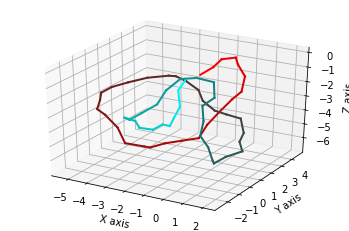

In [10]:
%matplotlib inline

polymer_id = 42

print(train_y[polymer_id])
print(train_x[polymer_id].shape)

plot_conformation([train_x[polymer_id]])

[0. 0. 0. 0. 1.]
(60, 3)


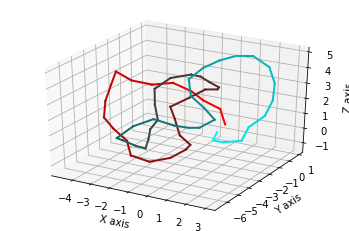

In [11]:
%matplotlib inline

polymer_id = 2024

print(train_y[polymer_id])
print(train_x[polymer_id].shape)

plot_conformation([train_x[polymer_id]])

[1. 0. 0. 0. 0.]
(60, 3)


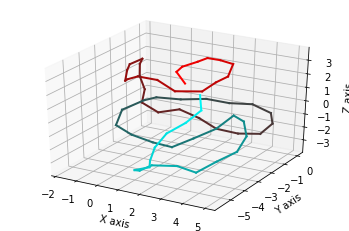

In [12]:
%matplotlib inline

polymer_id = 2023

print(train_y[polymer_id])
print(train_x[polymer_id].shape)

plot_conformation([train_x[polymer_id]])

### Normalize the xyz coordinate to relative positions

The inputs of the conformation for neural networks are deltas in x, y, z, i.e., the changes in monomer positions in the x, y, and z directions at every step.

To improve NN performance, we convert the trajectory of positions to their relative increments from the previous coordinate (Fig. 3). For example, a trajectory of X -coordinates [0, 0.8, 0.5, 1.4, 2.2] is converted
to [+0.8, −0.3, +0.9, +0.8].

Since the bond length, i.e., the distance between two adjacent monomers, is a unit length, this conversion yields an additional benefit of scaling the data in the [0, 1] range, akin to normalization.


In [13]:
train_x = np.diff(train_x, n=1, axis=1)
test_x = np.diff(test_x, n=1, axis=1)

print("snapshot of train_x[0, :3]: ", train_x[0, :3])
print("snapshot of test_x[0, :3]: ", test_x[0, :3])

max_train_x, min_train_x = np.max(train_x), np.min(train_x)
max_test_x, min_test_x = np.max(test_x), np.min(test_x)

print("maxmin for train_x: ", max_train_x, min_train_x)
print("maxmin for test_x: ", max_test_x, min_test_x)


# when using diff, chain_length -= 1
assert train_x.shape[1:] == (chain_length -1, 3)
assert test_x.shape[1:] == (chain_length -1, 3)

# dtype
assert (train_x.dtype, test_x.dtype, train_y.dtype, test_y.dtype) == ("float32", "float32", "float32", "float32")

snapshot of train_x[0, :3]:  [[-0.42895    -0.16353    -0.8884    ]
 [-0.46182    -0.67208    -0.57881993]
 [ 0.10544002 -0.89299005  0.43754995]]
snapshot of test_x[0, :3]:  [[ 0.58381    -0.78484     0.20781   ]
 [ 0.58548    -0.81058    -0.01322   ]
 [ 0.59142005 -0.25550997 -0.76482   ]]
maxmin for train_x:  1.0000002 -1.0000002
maxmin for test_x:  1.0000002 -1.0000001


### Verify the input before feeding them to the model

In [14]:
assert np.max(train_x[0]) < 1.0000005
assert np.min(train_x[0]) > -1.0000005
assert np.max(test_x[0]) < 1.0000005
assert np.min(test_x[0]) > -1.0000005

# test for x values
num_train_x = train_x.shape[0]
assert num_train_x == dataset_size * num_knot_types * split_pct // 100

assert train_x.shape[0] + test_x.shape[0] == (dataset_size * num_knot_types)

# chaing -=1 for using diff to normalize
assert train_x.shape == (num_train_x, chain_length-1, 3)

# test for y label
assert test_y.shape[0] + train_y.shape[0] == (dataset_size * num_knot_types)

if num_knot_types > 2:
    assert train_y.shape == (num_train_x, num_knot_types)
    rev_train_y = np.array([np.argmax(i, axis=None, out=None) for i in train_y])
    print(rev_train_y)
    rev_test_y = np.array([np.argmax(i, axis=None, out=None) for i in test_y])
    print(rev_test_y)

    assert np.count_nonzero(rev_train_y == 1) == np.count_nonzero(rev_train_y == 0)
    assert np.count_nonzero(rev_train_y == 1) == np.count_nonzero(rev_train_y == 2)
    assert np.count_nonzero(rev_train_y == 1) == np.count_nonzero(rev_train_y == 3)
    assert np.count_nonzero(rev_train_y == 1) == np.count_nonzero(rev_train_y == 4)
    assert np.count_nonzero(rev_test_y == 1) == np.count_nonzero(rev_test_y == 0)
    assert np.count_nonzero(rev_test_y == 1) == np.count_nonzero(rev_test_y == 2)
    assert np.count_nonzero(rev_test_y == 1) == np.count_nonzero(rev_test_y == 3)
    assert np.count_nonzero(rev_test_y == 1) == np.count_nonzero(rev_test_y == 4)
    
    assert np.count_nonzero(rev_train_y == 0) == dataset_size * split_pct // 100
else:
    assert train_y.shape == (num_train_x,)
    assert np.count_nonzero(train_y == 1) == np.count_nonzero(train_y == 0)
    assert np.count_nonzero(test_y == 1) == np.count_nonzero(test_y == 0)
    assert np.count_nonzero(train_y == 0) == dataset_size * split_pct // 100


assert len(train_y) + len(test_y) == dataset_size*num_knot_types
assert len(train_y) == dataset_size * num_knot_types * split_pct // 100


assert len(train_x) == len(train_y)
assert len(test_x) == len(test_y)

print("data sanity tests passed :)")

[0 1 2 ... 3 3 0]
[2 0 2 ... 3 2 1]
data sanity tests passed :)


## Build a model

We build a simple LSTM model with bidrectional layers and dropout.

The bidirectional layer is an important element as it sends information both forward and backward between sequence steps, effectively processing the sequence from both ends.

We want to leverage this forward and backward context-awareness to improve the predictive power of
the model when applied to knots in polymer chains, as the knot type is the same regardless of how the sequence is flipped.

In [15]:
%%time


# model initialization

model = models.Sequential()

model.add(LSTM(280, input_shape=(None,3), return_sequences=True))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.25))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(60))

if num_knot_types > 2:
    print("use multiclass")
    # for multiclass use softwax
    model.add(Dense(num_knot_types, activation='softmax'))
else:
    print("use binary")
    model.add(Dense(1, activation='sigmoid'))

model.summary()

use multiclass
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 280)         318080    
_________________________________________________________________
dropout (Dropout)            (None, None, 280)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 200)         304800    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 100)         120400    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None,

The number of trainable params (862,625) is the same as the one reported in Table 1 of the publication.

### Keras Callbacks

In [16]:
# for ModelCheckpoint and model saves
formatted_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_model_name = "{}_L{}_{}K_0-31-41-52-51_".format(
    formatted_time, chain_length, dataset_size//1000)

# checkpoint using save_best_only
# model weights are written to the file “temp_{save_model_name}.h5” only if
# the classification accuracy of the model on the validation dataset improves
# over the best seen so far.
filepath="temp_{}.h5".format(save_model_name)
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)


# simple early stopping
es = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
)

# for loss plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1, # usually 0.1
    patience=2,
    verbose=1
)

# combined callbacks list
callbacks_list = [
    reduce_lr,
    es,
    checkpoint
]

## Compile and Train

In [17]:
if num_knot_types > 2:
    print("use multiclass")
    # for multiclass
    # targets are one-hot encoded, use categorical_crossentropy as the loss;
    # if they’re integers, use sparse_categorical_crossentropy
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
else:
    print("use binary")
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

use multiclass


In [ ]:
history = model.fit(
    train_x,
    train_y,
    epochs=80,
    batch_size=2048,
    callbacks=callbacks_list,
    validation_split=0.2  # val = 0.9*0.2=18%
)

Epoch 1/80
352/352 [==============================] - 62s 161ms/step - loss: 1.4937 - accuracy: 0.2903 - val_loss: 1.1688 - val_accuracy: 0.4950

Epoch 00001: val_accuracy improved from -inf to 0.49497, saving model to temp_20240402-215209_L60_200K_0-31-41-52-51_.h5
Epoch 2/80
 27/352 [=>............................] - ETA: 47s - loss: 1.1717 - accuracy: 0.4952

### Training early stopped at ~98% training and validation accuracy

Training done for L60 polymers of 5 knot types, on a dataset of 200K for each knot type

### Plot the Training and validation Loss and Accuracy

In [ ]:
%matplotlib inline


history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

fig = plt.figure()
plt.plot(epochs, loss_values, 'bo', label="Training loss")
plt.plot(epochs, val_loss_values, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
%matplotlib inline


acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]


fig = plt.figure()
plt.plot(epochs, acc, 'ro', label="Training accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluation on Testset

Run inference on new data. Here we evaluate on the hold-out 10% test set.


In [ ]:
print("test_y.shape = ", test_y.shape)

test_loss, test_acc = model.evaluate(test_x, test_y)

### confusion matrix and other classification metrics

In [ ]:
predictions = model.predict(test_x)

In [ ]:
y_pred = np.argmax(predictions, axis=1)
print("y_pred = ", y_pred)

y_true = np.argmax(test_y, axis=1)
print("y_true = ", y_true)

In [ ]:
confusion_matrix(y_true, y_pred)

In [ ]:
# balanced_accuracy_score(y_true, y_pred, *[, ...]) Compute the balanced accuracy.
balanced_accuracy_score(y_true, y_pred)